In [1]:
# AlexNet 2012년 발표된 CNN 기반의 모형
# 특정: ReLU, MaxPooling, Dropout, Augmentation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import numpy as np

import copy
import random 
import time

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
ROOT = '.data'
train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)
means = train_data.data.mean(axis=(0,1,2)) / 255
stds = train_data.data.std(axis=(0,1,2)) / 255

print(means, stds)

100%|██████████| 170498071/170498071 [00:12<00:00, 14196143.35it/s]


Extracting .data\cifar-10-python.tar.gz to .data
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [15]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=means,
                         std=stds)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means,
                         std=stds)
])

In [16]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                              train=False,
                              download=True,
                              transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
VALID_RAITO = 0.9

n_train_examples = int(len(train_data) * VALID_RAITO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [18]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [19]:
len(train_data), len(valid_data), len(test_data)

(45000, 5000, 10000)

In [22]:
import torch

x = torch.rand(2,2)
print(x)
# add_(+1. 원본 변경)
x.add_(2) # x = x + 2
print(x)
# div_(/1, 원본 변경)
x.div_(2) # x = x / 2
print(x)

tensor([[0.7690, 0.9762],
        [0.9490, 0.1488]])
tensor([[2.7690, 2.9762],
        [2.9490, 2.1488]])
tensor([[1.3845, 1.4881],
        [1.4745, 1.0744]])


In [125]:
def plot_images(images, labels, classes):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i +1)

        image = images[i]

        image_min = image.min()
        image_max = image.max()
        image.clamp_(min=image_min, max=image_max) # min, max 설정(범위를 벗어나지 않도록)
        image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1,2,0).cpu().numpy()) # 차원 변경
        ax.set_title(classes[labels[i]])
        ax.axis('off')


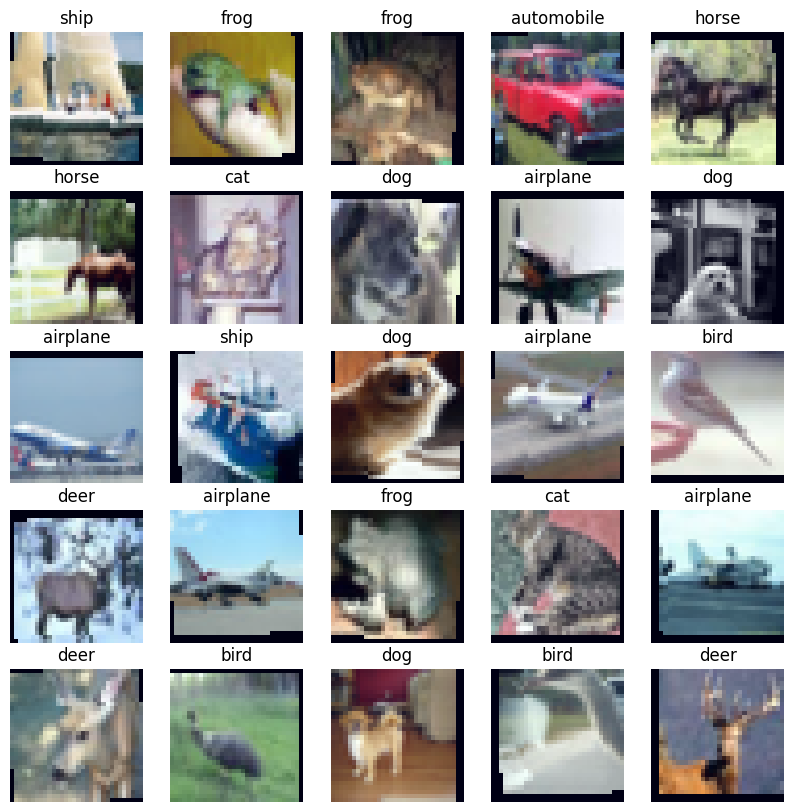

In [29]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes
plot_images(images, labels, classes)

In [30]:
# 이미지 정규화 함수
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [31]:
def plot_filter(images, filter):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3,3,1,1)
    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    # 0,1,2,3 => 0,2,3,1
    # samples, channel, width, height torch 형식
    # samples, width, height, channel matplotlib의 형식

    images = images.permute(0,2,3,1)
    filtered_images = filtered_images.permute(0,2,3,1)

    fig = plt.figure(figsize=(25,5))
    for i in range(n_images):
        image = images[i]
        image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]
        image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

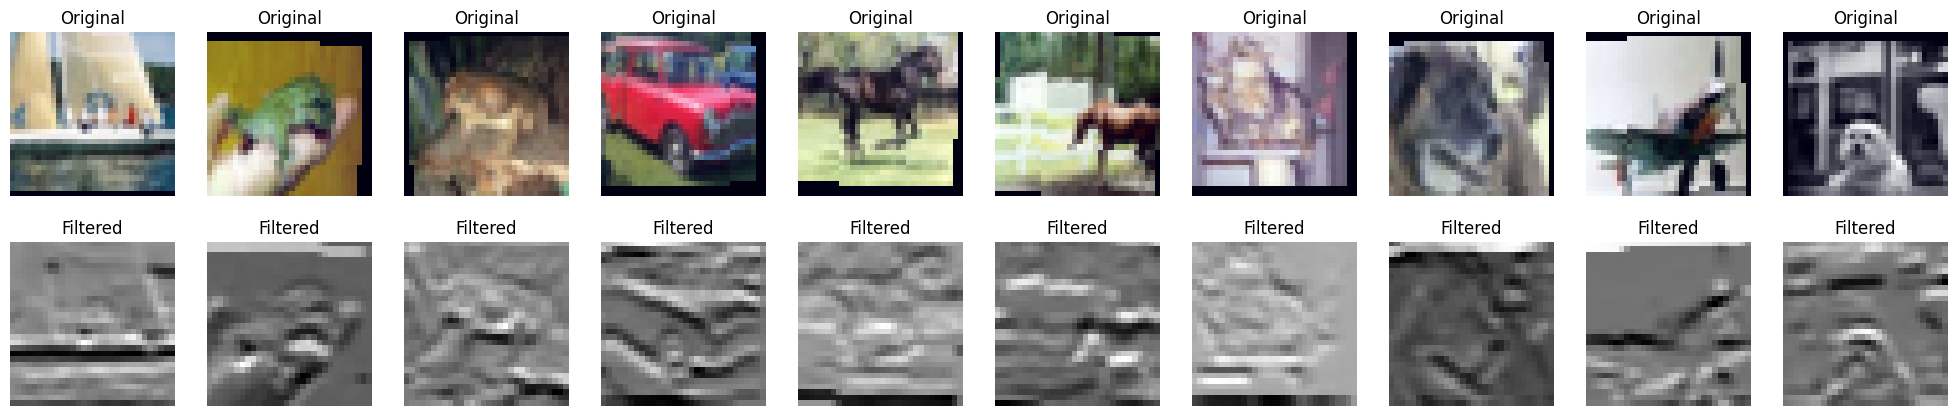

In [33]:
N_IMAGES = 10
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

# 수평선 감지 필터
horizontal_filter = [[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]]
plot_filter(images, horizontal_filter)

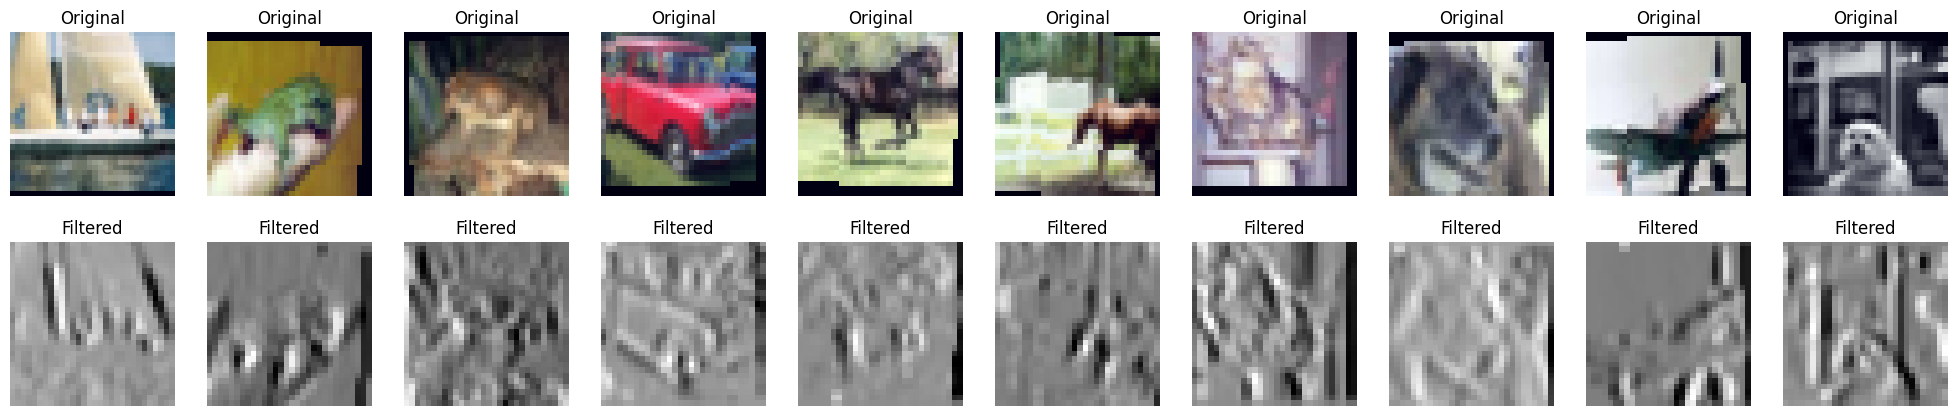

In [34]:
#수직선 감지 필터

vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

In [35]:
# 맥스풀링
def plot_subsample(images, pool_size):
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    pool = F.max_pool2d
    n_images = images.shape[0]
    pooled_images = pool(images, kernel_size=pool_size)

    images = images.permute(0,2,3,1)
    pooled_images = pooled_images.permute(0,2,3,1)

    fig = plt.figure(figsize=(25,5))

    for i in range(n_images):
        image = images[i]
        image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')
        image = pooled_images[i]
        image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Subampled')
        ax.axis('off')

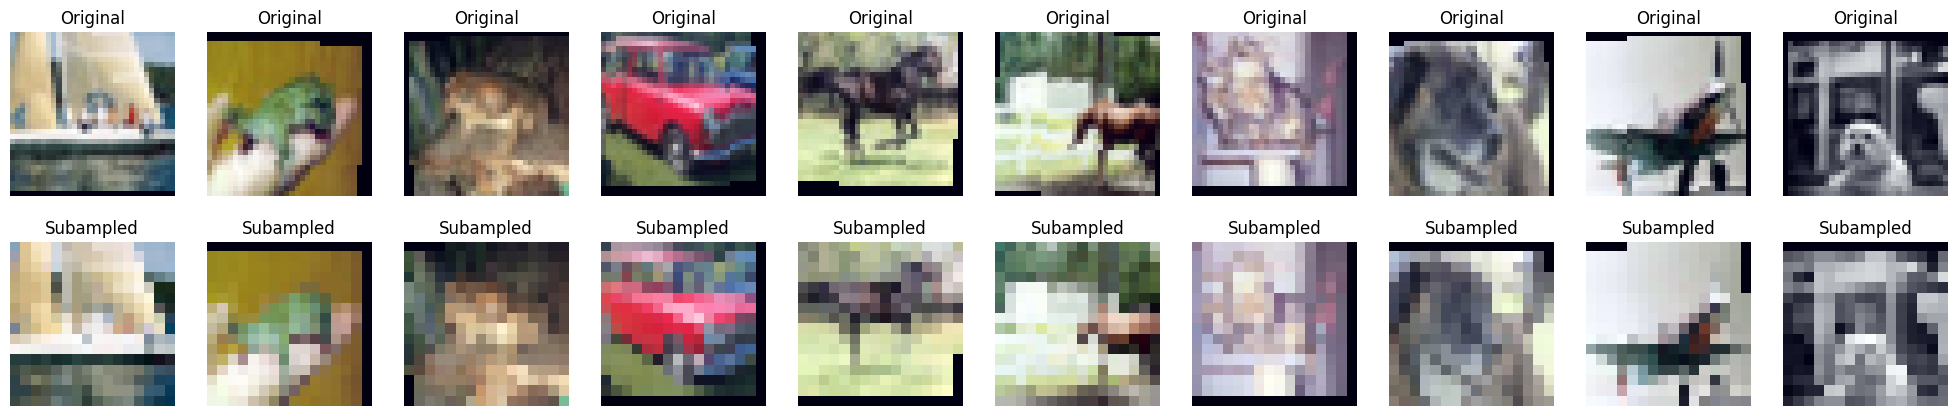

In [36]:
plot_subsample(images, 2) #2x2 맥스풀링(해상도가 낮아짐)

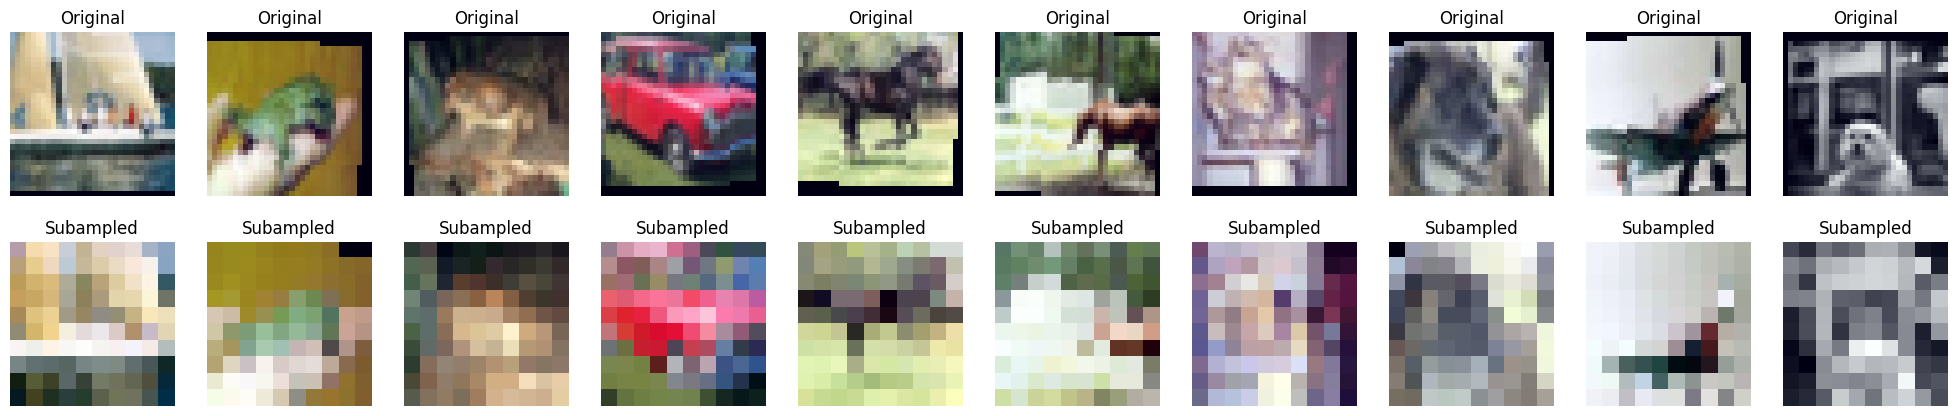

In [37]:
plot_subsample(images, 3) #3x3

In [83]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(test_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)                                 

In [84]:
class AlexNet(nn.Module):

    def __init__(self, output_dim):

        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding

            nn.MaxPool2d(2),  

            nn.ReLU(inplace=True),

            nn.Conv2d(64, 192, 3, padding=1),

            nn.MaxPool2d(2),

            nn.ReLU(inplace=True),

            nn.Conv2d(192, 384, 3, padding=1),

            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),

            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),

            nn.MaxPool2d(2),

            nn.ReLU(inplace=True)

        )

        self.classifier = nn.Sequential(

            nn.Dropout(0.5),

            nn.Linear(256 * 2 * 2, 4096),

            nn.ReLU(inplace=True), #텐서 직접 수정, 기본값 false

            nn.Dropout(0.5),

            nn.Linear(4096, 4096),

            nn.ReLU(inplace=True),

            nn.Linear(4096, output_dim),

        )

    def forward(self, x):

        x = self.features(x)

        h = x.view(x.shape[0], -1)

        x = self.classifier(h)

        return x, h



In [85]:
OUTPUT_DIM = 10
model = AlexNet(OUTPUT_DIM)

In [86]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [87]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters

<function __main__.count_parameters(model)>

In [88]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [89]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [90]:
def train(model, iterator, optimizer, cirterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x,y) in tqdm(iterator, desc='Training', leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [91]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x,y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += loss.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [78]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [79]:
EPOCHS = 2
best_valid_loss = float('inf')
for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 36s
	Train Loss: 1.796 | Train Acc: 30.50%
	 Val. Loss: 1.482 |  Val. Acc: 148.22%


Epoch: 02 | Epoch Time: 1m 40s
	Train Loss: 1.413 | Train Acc: 47.70%
	 Val. Loss: 1.315 |  Val. Acc: 131.46%



In [92]:
model.load_state_dict(torch.load('tut3-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.315 | Test Acc: 131.46%


In [97]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [98]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [99]:
pred_labels = torch.argmax(probs, 1)

In [102]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

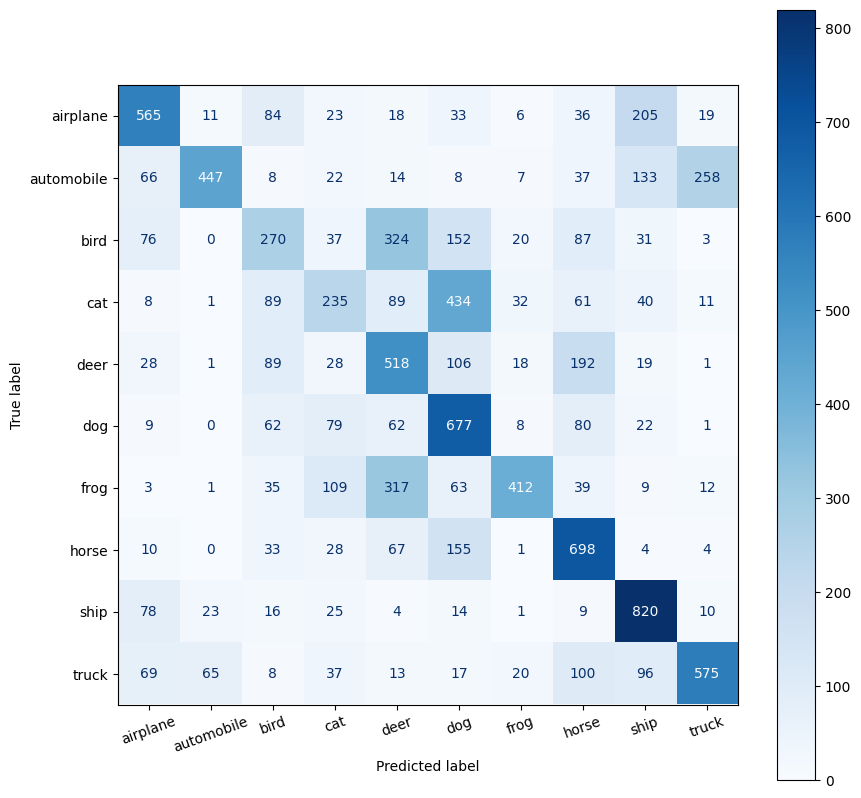

In [103]:
plot_confusion_matrix(labels, pred_labels, classes)

In [104]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [105]:
def plot_most_incorrect(incorrect, classses, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25,20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1,2,0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
        f'pred label: {incorrect_class} ({incorrect_prob: .3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

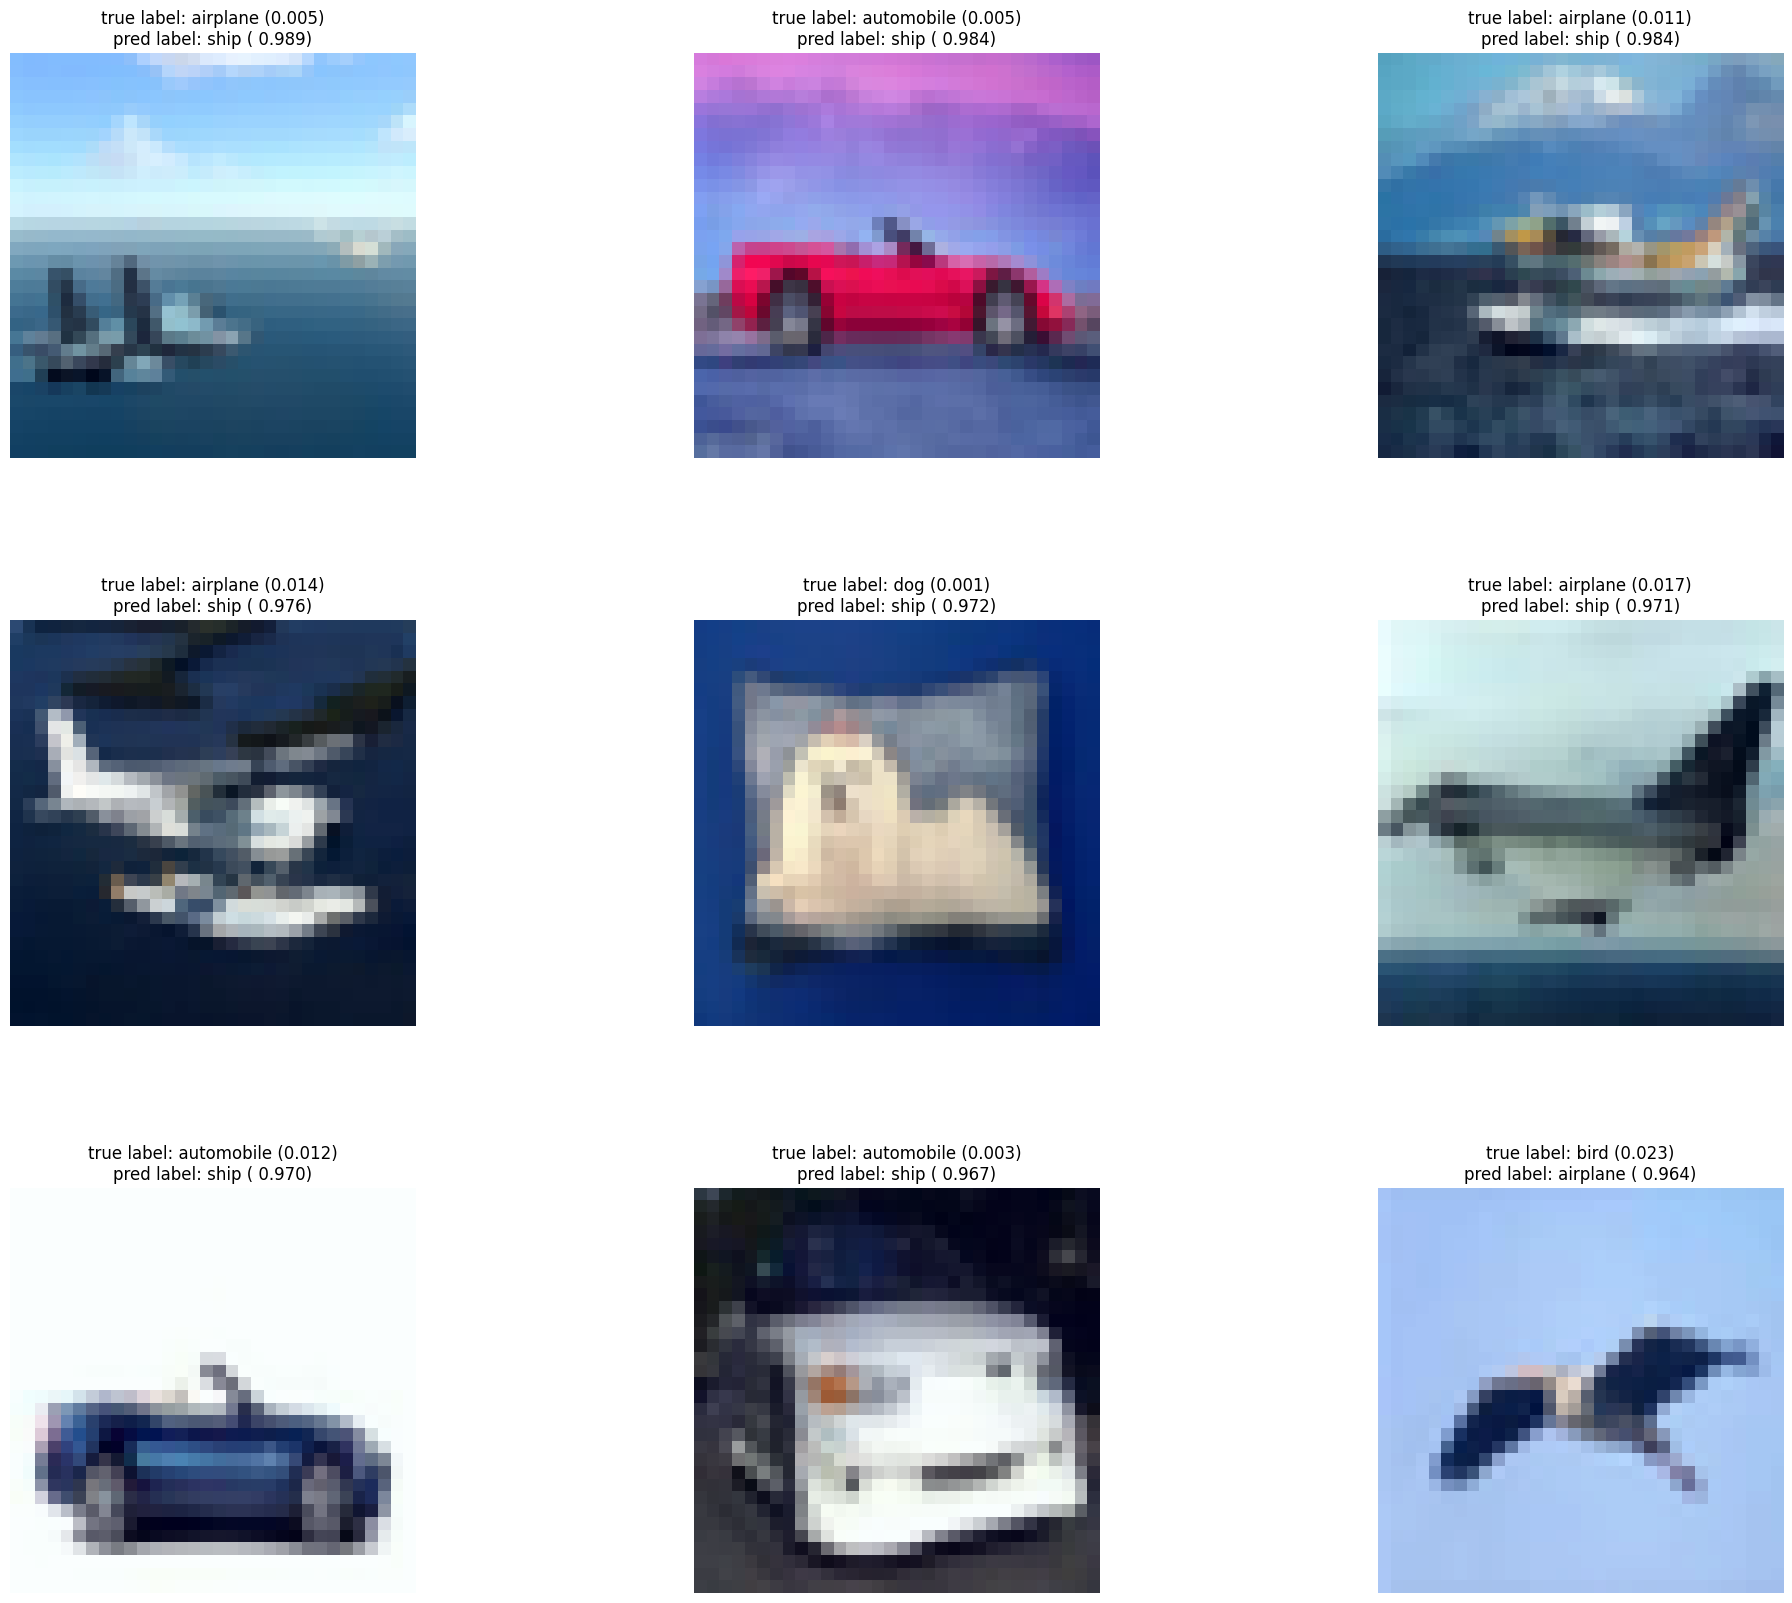

In [106]:
N_IMAGE = 36
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [109]:
def get_representations(model, iterator, device):
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x,y) in tqdm(iterator):
            x = x.to(device)
            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [111]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

In [112]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data


In [113]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

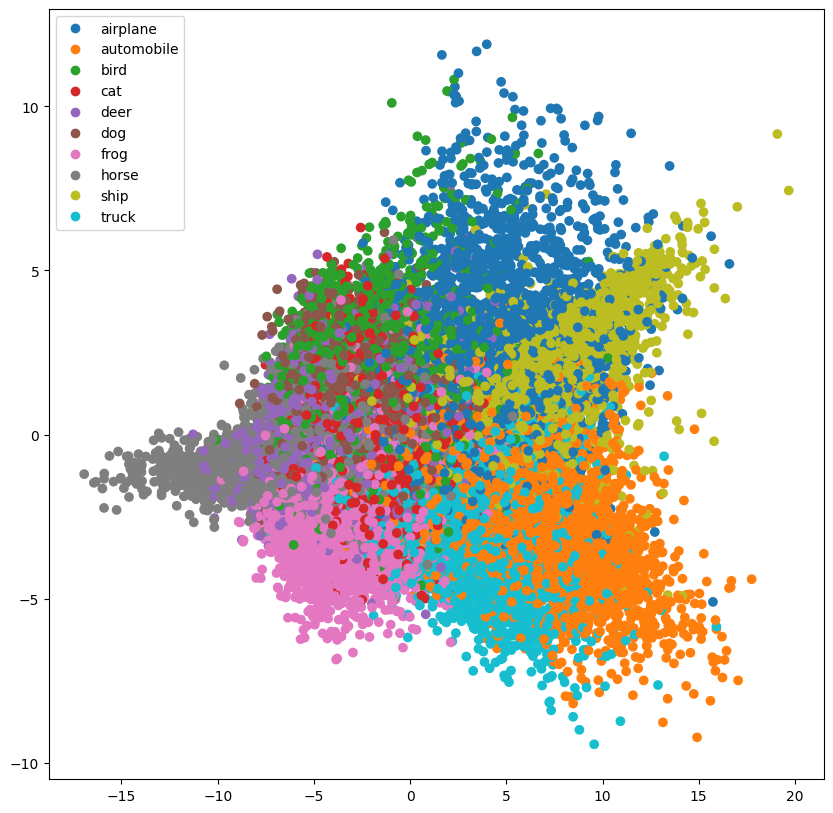

In [115]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

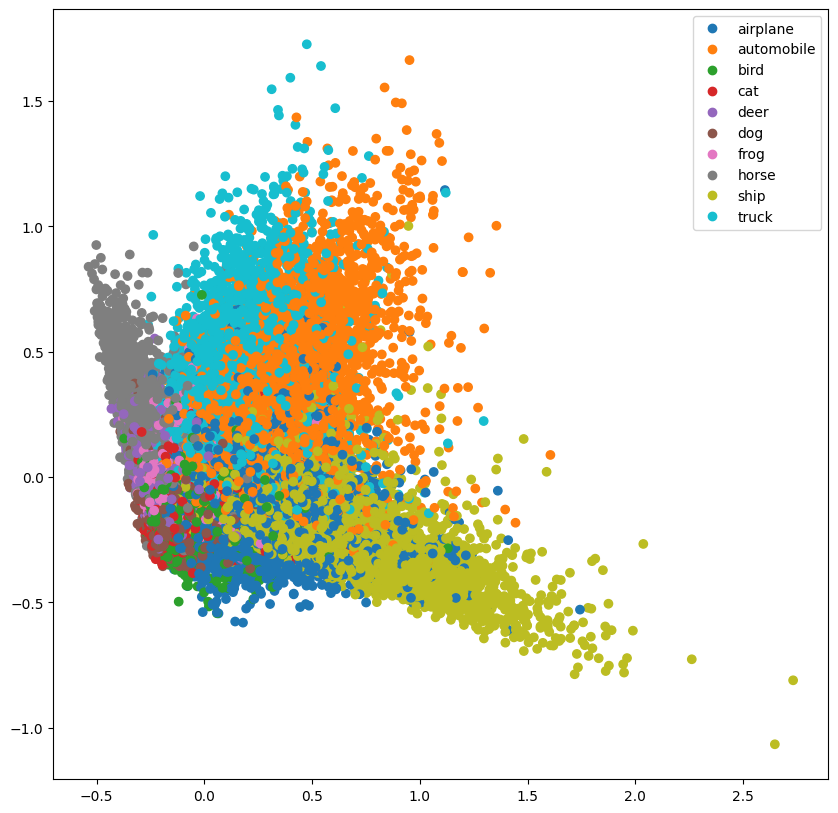

In [116]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

In [117]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


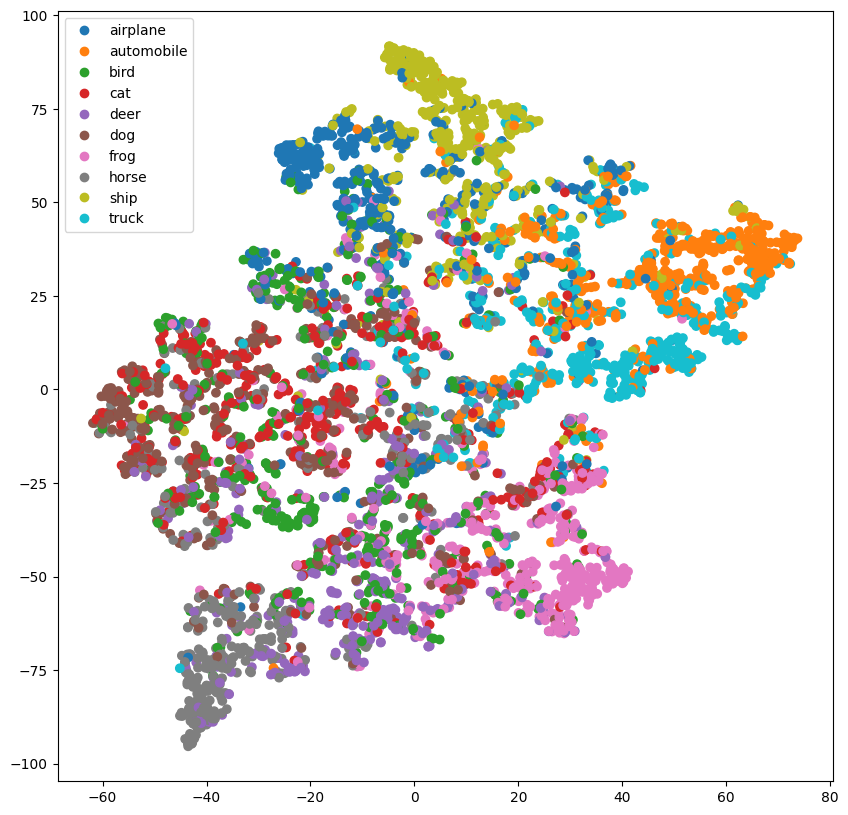

In [121]:
N_IMAGES = 5000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


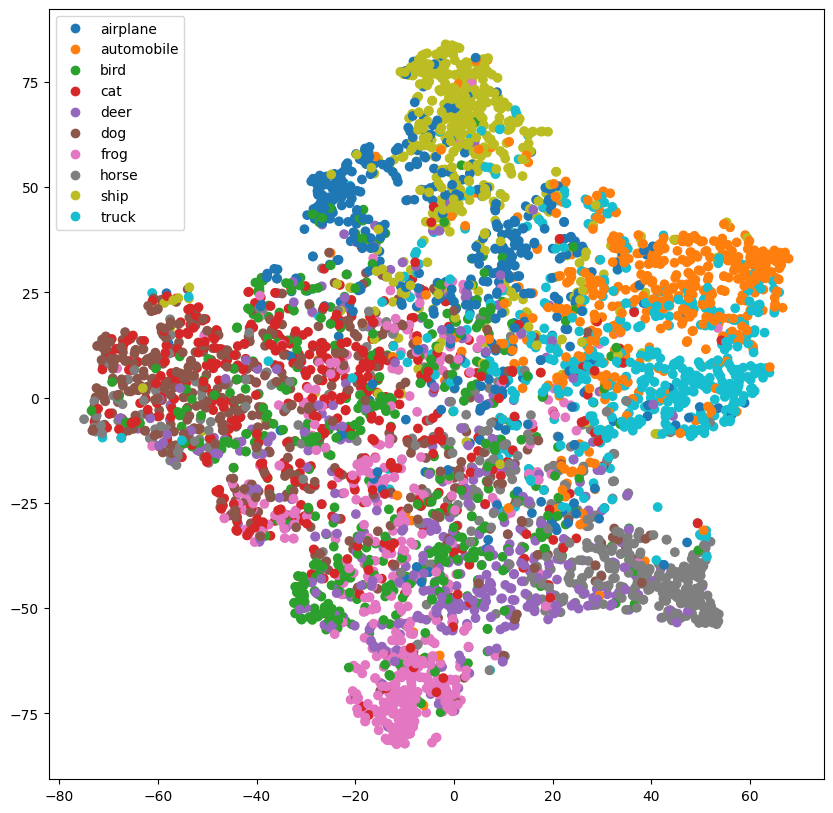

In [124]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)
